# Using Deep Learning for Essay Score Prediction - Transformers
## Overview

BERT for text regression

#### Approach
- Split this data set into two sets - one for training our DL model, and one for evaluation  
- Use Keras to create BERT Model with multiple layers. We will train this model on both CPU environments  
- Evaluate and test the model on the test set and look at a few individual examples

In [1]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from multiprocessing import cpu_count
print(cpu_count())

16


In [2]:
# %pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True)

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential

In [5]:
df_proc=pd.read_csv('../00_gcp_data/preprocessed-essay.csv')
# df_proc.head()

In [15]:
pd.options.display.max_colwidth=None
df_proc[['corrected_text','lemmatized_text']].head(2)

,corrected_text,lemmatized_text
0,think students would benefit learning home wont change get early morning shower hair taking classes helps house pay attention comfortable home hardest part school getting ready wake brush teeth closet look cloths think picked outfit look mirror you'll either like look see stain change online classes wear anything stay home wont need stress wear students usually take showers school either take sleep wake students smell good causes miss bus effects lesson time cause come late school online classes wont need miss lessons cause get everything set take shower get ready home comfortable pay attention gives advantage smarter even pass classmates class work public schools difficult even try teacher done know teach way students understand causes students fail may repeat class,think student would benefit learn home wont change get early morning shower hair take class help house pay attention comfortable home hardest part school get ready wake brush teeth closet look cloth think picked outfit look mirror you'll either like look see stain change online class wear anything stay home wont need stress wear student usually take shower school either take sleep wake student smell good cause miss bus effect lesson time cause come late school online class wont need miss lesson cause get everything set take shower get ready home comfortable pay attention give advantage smarter even pas classmate class work public school difficult even try teacher do know teach way student understand cause student fail may repeat class
1,problem change let best matter happening change mind sometimes need wake look around problems best way change want change along time ago problem change make see different help understand tings wok first make see different others example remember came united states think nothing going change think nothing going change everything different country realist wrong problem may change sometimes change way remember really shy think change lot sometimes problems make think thing never see life need see different way done let nothing happened ring change want make problem example think nothing going change done need shy anymore became need start seeing everything different ways get mad every one need know going happened people may see different way know change best let nothing body change nothing way want change one nothing choice problems decide second help understand things work instance mon lot problems faith around people mon scare high scare high understand mos scare high scare high every time see mon airline make laugh scare funny see different way like high also understand hoe things work people example think mon different understand like high need understand help someone understand things work need start see things work persons life problem change make different help understand everyone different opinion different understand others everyone see different opinion people think,problem change let best matter happen change mind sometimes need wake look around problem best way change want change along time ago problem change make see different help understand ting wok first make see different others example remember come united state think nothing go change think nothing go change everything different country realist wrong problem may change sometimes change way remember really shy think change lot sometimes problem make think thing never see life need see different way do let nothing happen ring change want make problem example think nothing go change do need shy anymore become need start see everything different way get mad every one need know go happen people may see different way know change best let nothing body change nothing way want change one nothing choice problem decide second help understand thing work instance mon lot problem faith around people mon scare high scare high understand mo scare high scare high every time see mon airline make laugh scare funny see different way like high also unde

In [22]:
df_proc['len_tokens']=df_proc['corrected_text'].apply(lambda x: len(x.split()))
df_proc['len_tokens'].describe()

count    3911.000000
mean      194.074406
std        84.965778
min         7.000000
25%       133.000000
50%       181.000000
75%       240.000000
max       551.000000
Name: len_tokens, dtype: float64

In [20]:
essay="think student would benefit learn home wont change get early morning shower hair take class help house pay attention comfortable home hardest part school get ready wake brush teeth closet look cloth think picked outfit look mirror you'll either like look see stain change online class wear anything stay home wont need stress wear student usually take shower school either take sleep wake student smell good cause miss bus effect lesson time cause come late school online class wont need miss lesson cause get everything set take shower get ready home comfortable pay attention give advantage smarter even pas classmate class work public school difficult even try teacher do know teach way student understand cause student fail may repeat class"
list_essay=essay.split()
list_essay

['think',
 'student',
 'would',
 'benefit',
 'learn',
 'home',
 'wont',
 'change',
 'get',
 'early',
 'morning',
 'shower',
 'hair',
 'take',
 'class',
 'help',
 'house',
 'pay',
 'attention',
 'comfortable',
 'home',
 'hardest',
 'part',
 'school',
 'get',
 'ready',
 'wake',
 'brush',
 'teeth',
 'closet',
 'look',
 'cloth',
 'think',
 'picked',
 'outfit',
 'look',
 'mirror',
 "you'll",
 'either',
 'like',
 'look',
 'see',
 'stain',
 'change',
 'online',
 'class',
 'wear',
 'anything',
 'stay',
 'home',
 'wont',
 'need',
 'stress',
 'wear',
 'student',
 'usually',
 'take',
 'shower',
 'school',
 'either',
 'take',
 'sleep',
 'wake',
 'student',
 'smell',
 'good',
 'cause',
 'miss',
 'bus',
 'effect',
 'lesson',
 'time',
 'cause',
 'come',
 'late',
 'school',
 'online',
 'class',
 'wont',
 'need',
 'miss',
 'lesson',
 'cause',
 'get',
 'everything',
 'set',
 'take',
 'shower',
 'get',
 'ready',
 'home',
 'comfortable',
 'pay',
 'attention',
 'give',
 'advantage',
 'smarter',
 'even',
 '

#### Limiting Essay to 512 words for BERT

In [47]:
df_proc['lemmatized_text_BERT']=df_proc['lemmatized_text'].parallel_apply(lambda x: ' '.join(x.split()[:512]))
df_proc['lemmatized_text_BERT'].head(2)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        think student would benefit learn home wont change get early morning shower hair take class help house pay attention comfortable home hardest part school get ready wake brush teeth closet look cloth think picked outfit look mirror you'll either like look see stain change online class wear anything stay home wont need stress wear student usually take shower school either take sleep

### Setting variables and helper functions

In [48]:
## Setting text and target variables
df_proc_2=df_proc[["lemmatized_text_BERT","cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]
df_proc_2.head(2)

,lemmatized_text_BERT,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,think student would benefit learn home wont change get early morning shower hair take class help house pay attention comfortable home hardest part school get ready wake brush teeth closet look cloth think picked outfit look mirror you'll either like look see stain change online class wear anything stay home wont need stress wear student usually take shower school either take sleep wake student smell good cause miss bus effect lesson time cause come late school online class wont need miss lesson cause get everything set take shower get ready home comfortable pay attention give advantage smarter even pas classmate class work public school difficult even try teacher do know teach way student understand cause student fail may repeat class,3.5,3.5,3.0,3.0,4.0,3.0
1,problem change let best matter happen change mind sometimes need wake look around problem best way change want change along time ago problem change make see different help understand ting wok first make see different others example remember come united state think nothing go change think nothing go change everything different country realist wrong problem may change sometimes change way remember really shy think change lot sometimes problem make think thing never see life need see different way do let nothing happen ring change want make problem example think nothing go change do need shy anymore become need start see everything different way get mad every one need know go happen people may see different way know change best let nothing body change nothing way want change one nothing choice problem decide second help understand thing work instance mon lot problem faith around people mon scare high scare high understand mo scare high scare high every time see mon airline make laugh scare funny see different way like high also understand hoe thing work people example think mon different understand like high need understand help someone understand thing work need start see thing work person life problem change make different help understand everyone different opinion different understand others everyone see different opinion people think,2.5,2.5,3.0,2.0,2.0,2.5


In [49]:
X = df_proc_2[["lemmatized_text_BERT"]]
Y = df_proc_2[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 1010)

### Cost function and hyperparameters

In [72]:
BATCH_SIZE = 10

MAX_LEN = max(len(x.split()) for x in df_proc_2['lemmatized_text_BERT'])
print(MAX_LEN)

# MAX_LEN=512. #CHANGEEEEE

512


### Importing transformers

In [73]:
tf.keras.backend.clear_session()
tf.config.run_functions_eagerly(True)

In [74]:
# import transfomers
import torch
from transformers import BertTokenizer , TFBertModel 

AUTO = tf.data.experimental.AUTOTUNE

In [75]:
bert_path = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [76]:
# tokenizer.vocab.items()

In [77]:
def encode(input_text):
    inputs = tokenizer.batch_encode_plus(input_text,padding='max_length',max_length=MAX_LEN, truncation=True)
    return inputs

In [78]:
# creating the tokenized training dataset
train_input = encode(X_train['lemmatized_text_BERT'].values.tolist())['input_ids']

In [79]:
train_data_ds = (
    tf.data.Dataset
    .from_tensor_slices((train_input,Y_train))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
train_data_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>

In [80]:
# creating the tokenized testing dataset
testing_input = encode(X_test['lemmatized_text_BERT'].values.tolist())['input_ids']

test_data_ds = (
    tf.data.Dataset
    .from_tensor_slices((testing_input,Y_test))
    .batch(BATCH_SIZE)
)

test_data_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>

---
### Creating the Baseline BERT Model

In [81]:
# Custom error function MCRMSE : column wise root mean squared eoor

def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)


In [99]:
def create_model_BERT1():
    bert_encoder = TFBertModel.from_pretrained(bert_path)
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
    
    embedding = bert_encoder(input_word_ids)[0]
    
    x = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    x = tf.keras.layers.LayerNormalization()(x)
    
    #Output layer without activation function because regression task
    output = tf.keras.layers.Dense(6,)(x)

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=MCRMSE
                  , metrics=MCRMSE)

    return model

In [100]:
mod_BERT1= create_model_BERT1()
mod_BERT1.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model_2 (TFBertMode  TFBaseModelOutputWithPoo  109482240
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [84]:
# %pip install pydot
# %pip install pydotplus
# !sudo apt-get install graphviz -y

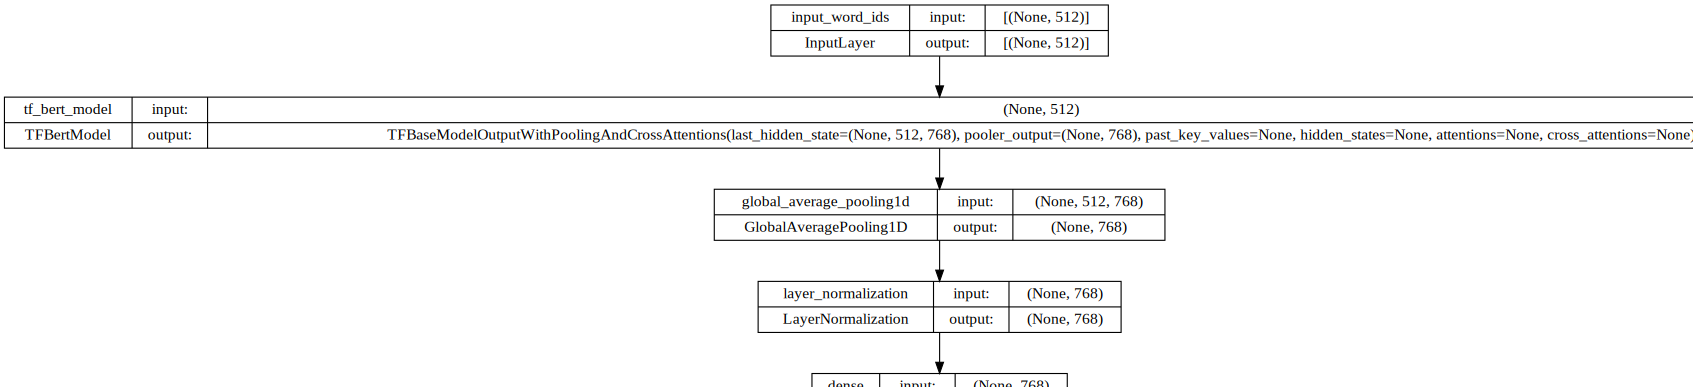

In [97]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
svg_image=SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))
svg_image

In [102]:
%%time
from tensorflow.keras.callbacks import *
import os
reduce_lr = ReduceLROnPlateau(monitor = 'val_MCRMSE', factor = 0.25, patience = 2, verbose = 1)
earlystop = EarlyStopping(monitor = 'val_MCRMSE',  mode="min", min_delta = 0, patience = 25,verbose = 1)

filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/BERT_Baseline1"
checkpoint = ModelCheckpoint(filepath, monitor='val_MCRMSE',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

#only save model if it reduces MSE
callbacks = [reduce_lr,earlystop,checkpoint]

t1 = time.time()
mod_BERT1_history = mod_BERT1.fit(train_data_ds,
                    steps_per_epoch= X_train.shape[0]//BATCH_SIZE,
                    batch_size = BATCH_SIZE,
                    epochs= 1,
                    verbose = 1,
                    shuffle= True,
                    validation_data=test_data_ds,
                    callbacks=[callback])
t2 = time.time()
print("BERT model train time = %d seconds" %(t2-t1))

312/312 [==============================] - 4849s 16s/step - loss: 0.6179 - MCRMSE: 0.6179 - val_loss: 0.5659 - val_MCRMSE: 0.5651
BERT model train time = 4849 seconds
CPU times: user 13h 27min 19s, sys: 2h 14min 38s, total: 15h 41min 58s
Wall time: 1h 20min 49s


In [103]:
mod_BERT1_history.history.keys()

dict_keys(['loss', 'MCRMSE', 'val_loss', 'val_MCRMSE'])

In [107]:
mod_BERT1.save('mod_BERT1.h5')

In [110]:
print(mod_BERT1_history.history)

{'loss': [0.617926836013794], 'MCRMSE': [0.617927074432373], 'val_loss': [0.5659112334251404], 'val_MCRMSE': [0.5651324987411499]}


In [112]:
import json
with open('mod_BERT1_history.json', 'w') as f:
    json.dump(mod_BERT1_history.history, f)